In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import copy

In [2]:
def readQAP(name):
    """
    Leer un archivo DAT y lo transforma en un diccionario que contiene el número de nodos (n), matriz de flujo (f) 
    y matriz de distancia (d)

    Args:
        name (str): Nombre del archivo .dat a leer

    Returns:
        instance_dict (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d)
    """
    with open(name, 'r') as file:
        lines = file.readlines()
        
    n_nodos = int(lines[0])
    flow_matrix = np.array([list(map(int, line.split())) for line in lines[1:n_nodos+1]])
    distance_matrix = np.array([list(map(int, line.split())) for line in lines[n_nodos+2:2*n_nodos+2]])
    
    instance_dict = {'n': n_nodos, 'f': flow_matrix, 'd': distance_matrix}
    
    return instance_dict

def evaluateQAP(sol, f, d):
    """
    Evaluar QAP con una solución dada

    Args:
        sol (numpy array): vector con valores de posición para evaluar la función
        f (numpy array): matriz de flujo entre nodos
        d (numpy array): matriz de distancia entre nodos

    Returns:
        Valor de fitness del QAP en base a la solución entregada
    """
    
    fitness = np.sum(f * d[sol[:, None], sol])
    
    return fitness

def generateInitialSolution(n):
    """
    Generar una solución inicial para el problema QAP

    Args:
        n (int): El número de nodos en el problema QAP

    Returns:
        sol_ini (numpy array): Una permutación aleatoria de los números del 0 al n-1
    """
    sol_ini = np.random.permutation(n)
    return sol_ini

def inversion(sol, i):
    """
    Aplica el operador de inversión a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.
        i (int): Valor de posición intermedio al cual se le aplicará el operador de inversión.

    Returns:
        sol (numpy array): Vector con operador de inversión ya aplicado.
    """
    temp = sol[i:i+2].copy()
    sol[i:i+2] = sol[i+2:i+4][::-1]
    sol[i+2:i+4] = temp[::-1]
    return sol


def swap(sol, i, j):
    """
    Aplica el operador de swap a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.
        i, j (int): Indices de los elementos a intercambiar.

    Returns:
        sol (numpy array): Vector con operador de swap ya aplicado.
    """
    sol[i], sol[j] = sol[j], sol[i]
    return sol

def permutation(sol):
    """
    Aplica el operador de permutación a una solución dada.

    Args:
        sol (numpy array): Vector con valores de posición para evaluar la función.

    Returns:
        sol (numpy array): Vector con operador de permutación ya aplicado.
    """
    n = len(sol)
    length = np.random.randint(1, n//2 + 1)  # length of segments to swap
    i = np.random.randint(0, n - 2*length + 1)  # start index of first segment
    j = np.random.randint(i + length, n - length + 1)  # start index of second segment
    temp_i = copy.deepcopy(sol[i:i+length])
    temp_j = copy.deepcopy(sol[j:j+length])
    sol[i:i+length], sol[j:j+length] = temp_j, temp_i
    return sol

def insertion(sol):
    n = len(sol)
    # Seleccione dos índices diferentes
    i, j = np.random.choice(n, 2, replace=False)
    # Retire el elemento en el índice j e insértelo en el índice i
    sol = np.insert(np.delete(sol, j), i, sol[j])
    return sol

def displacement(sol):
    n = len(sol)
    # Seleccione dos índices diferentes para definir un segmento
    i, j = np.sort(np.random.choice(n, 2, replace=False))
    # Crea una copia del segmento que se va a desplazar
    segment = np.copy(sol[i:j+1])
    # Elimina el segmento de la solución
    sol = np.delete(sol, range(i, j+1))
    # Seleccione un índice para el nuevo lugar del segmento
    k = np.random.choice(len(sol) + 1)
    # Desplace el segmento a la nueva posición
    sol = np.insert(sol, k, segment)
    return sol



def calculate_initial_temperature(instance, sol, p0=0.5, n_iter=100):
    """
    Calcula la temperatura inicial para el algoritmo de Simulated Annealing.

    Args:
        instance (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d).
        sol (numpy array): Solución inicial.
        p0 (float, optional): Probabilidad inicial. Por defecto es 0.5.
        n_iter (int, optional): Número de iteraciones para calcular la temperatura inicial. Por defecto es 100.

    Returns:
        t_initial (float): Temperatura inicial.
    """
    deltas = np.zeros(n_iter)
    cost_temp = evaluateQAP(sol, instance['f'], instance['d'])

    for i in range(n_iter):
        sol_temp = inversion(sol.copy(), np.random.randint(0, instance['n'] - 4))
        new_cost = evaluateQAP(sol_temp, instance['f'], instance['d'])
        deltas[i] = new_cost - cost_temp
        cost_temp = new_cost

    delta_average = np.mean(np.abs(deltas))
    t_initial = -delta_average / np.log(p0)

    return t_initial


def simulated_annealing(instance, xj_ini, operator, max_iter, max_iter_interna, alpha):
    """
    Calcula el menor costo al aplicar el algoritmo de S.A a una función objetivo dada.
    
    Args:
        instance (dict): Diccionario que contiene el número de nodos (n), matriz de flujo (f) y matriz de distancia (d).
        xj_ini (numpy array): Vector que contiene una configuración inicial de Xj para el modelo SIC
        operator (str): Nombre del operador a aplicar. Puede ser "swap" o "inversion"
        max_iter (int): Número de iteraciones máximas a realizar por el ciclo externo del algoritmo.
        max_iter_interna (int): Número máximo de iteraciones a realizar por el ciclo interno del algoritmo.
        alpha (float): Factor de enfriamiento de la temperatura por cada nuevo ciclo

    Returns:
        mejor_xj (numpy array): mejor configuración de Xj encontrada
        mejor_cost: mínimo valor de costo encontrado para el problema QAP
        eval_cost: costos de la solución actual para cada iteración
        eval_mejor: mejor costo encontrado para cada iteración
        temp: evolución de la temperatura para cada iteración
    """
    eval_cost = []
    eval_mejor = []
    temp = []

    xj = xj_ini.copy()
    mejor_xj = xj.copy()

    cost = evaluateQAP(xj, instance['f'], instance['d'])
    mejor_cost = cost

    t_inicial = calculate_initial_temperature(instance, xj, 0.5)
    t = t_inicial

    for iter_externa in range(max_iter):
        for iter_interna in range(max_iter_interna):
            if operator == "swap":
                i, j = np.random.choice(range(instance['n']), 2, replace=False)
                xj_test = swap(xj.copy(), i, j)
                
            elif operator == "inversion":
                i = np.random.choice(range(instance['n'] - 4))
                xj_test = inversion(xj.copy(), i)
                
            elif operator == "permutation":
                xj_test = permutation(xj.copy())
                
            elif operator == "insertion":
                xj_test = insertion(xj.copy())
                
            elif operator == "displacement":
                xj_test = displacement(xj.copy())

            cost_test = evaluateQAP(xj_test, instance['f'], instance['d'])

            delta_cost = cost - cost_test

            if np.exp(delta_cost / t) > np.random.rand():
                xj = xj_test
                cost = cost_test

            if cost_test < mejor_cost:
                mejor_xj = xj_test
                mejor_cost = cost_test

        eval_cost.append(cost)
        eval_mejor.append(mejor_cost)
        temp.append(t)

        t = t * alpha
        
    results_dict = {
        'mejor_xj': mejor_xj,
        'mejor_cost': mejor_cost,
        'eval_cost': eval_cost,
        'eval_mejor': eval_mejor,
        'temp': temp
    }
    
    return results_dict

def plot_convergence(results_dict):
    """Grafica la curva de convergencia de los costos y la temperatura.
    
    Args:
        results_dict (dict): Diccionario con los resultados del algoritmo.
    """
    # Crear una figura y un conjunto de subtramas
    fig, ax1 = plt.subplots()

    # Graficar los costos en el primer eje
    ax1.plot(results_dict['eval_cost'], label='Costo actual', color='blue')
    ax1.plot(results_dict['eval_mejor'], label='Mejor costo', color='green')
    ax1.set_xlabel('Iteraciones')
    ax1.set_ylabel('Costo')
    ax1.legend(loc='upper left')

    # Crear un segundo eje para la temperatura
    ax2 = ax1.twinx()
    ax2.plot(results_dict['temp'], label='Temperatura', color='red')
    ax2.set_ylabel('Temperatura')
    ax2.legend(loc='upper right')

    # Mostrar el gráfico
    plt.show()

    


In [3]:
class StateSpace:
    def __init__(self, n_bins=10):
        self.n_bins = n_bins
        self.cost_bins = None
        self.temperature_bins = None

    def fit(self, costs, temperatures):
        self.cost_bins = np.linspace(min(costs), max(costs), self.n_bins)
        self.temperature_bins = np.linspace(min(temperatures), max(temperatures), self.n_bins)

    def transform(self, cost, temperature):
        cost_idx = np.digitize(cost, self.cost_bins)
        temperature_idx = np.digitize(temperature, self.temperature_bins)
        return cost_idx, temperature_idx
    


# Entradas y Parámetros

In [4]:
instance = readQAP("../DAT/tho40.dat")
sol_ini = generateInitialSolution(instance['n']) 

In [5]:
max_iter = 500
max_iter_interna = 50
alpha = 0.8

# Entrenar State Space

In [6]:
state_space = StateSpace(n_bins=10)

costs = []
temperatures = []

for _ in range(50):
    results = simulated_annealing(instance, sol_ini, "swap", max_iter, max_iter_interna, alpha)
    costs.extend(results['eval_cost'])
    temperatures.extend(results['temp'])

lower_bound_costs = np.percentile(costs, 1)
upper_bound_costs = np.percentile(costs, 99)
adjusted_costs = np.clip(costs, lower_bound_costs, upper_bound_costs)

lower_bound_temperatures = np.percentile(temperatures, 1)
upper_bound_temperatures = np.percentile(temperatures, 99)
adjusted_temperatures = np.clip(temperatures, lower_bound_temperatures, upper_bound_temperatures)

state_space.fit(adjusted_costs, adjusted_temperatures)


C:\Users\mbell\AppData\Local\Temp\ipykernel_3036\2458886759.py:210: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


In [7]:
def simulated_annealing_state(instance, xj_ini, operator, max_iter, max_iter_interna, alpha, state_space):
    eval_cost = []
    eval_mejor = []
    temp = []

    xj = xj_ini.copy()
    mejor_xj = xj.copy()

    cost = evaluateQAP(xj, instance['f'], instance['d'])
    mejor_cost = cost

    t_inicial = calculate_initial_temperature(instance, xj, 0.5)
    t = t_inicial

    for iter_externa in range(max_iter):
        
        print(iter_externa)
        
        for iter_interna in range(max_iter_interna):
            
           
            
            if operator == "swap":
                i, j = np.random.choice(range(instance['n']), 2, replace=False)
                xj_test = swap(xj.copy(), i, j)
                
            elif operator == "inversion":
                i = np.random.choice(range(instance['n'] - 4))
                xj_test = inversion(xj.copy(), i)
                
            elif operator == "permutation":
                xj_test = permutation(xj.copy())
                
            elif operator == "insertion":
                xj_test = insertion(xj.copy())
                
            elif operator == "displacement":
                xj_test = displacement(xj.copy())

            cost_test = evaluateQAP(xj_test, instance['f'], instance['d'])
            
            # Se transforma el costo y la temperatura en un estado
            state = state_space.transform(cost_test, t)
            print(state)

            delta_cost = cost - cost_test

            if np.exp(delta_cost / t) > np.random.rand():
                xj = xj_test
                cost = cost_test

            if cost_test < mejor_cost:
                mejor_xj = xj_test
                mejor_cost = cost_test

        eval_cost.append(cost)
        eval_mejor.append(mejor_cost)
        temp.append(t)

        t = t * alpha
        
    results_dict = {
        'mejor_xj': mejor_xj,
        'mejor_cost': mejor_cost,
        'eval_cost': eval_cost,
        'eval_mejor': eval_mejor,
        'temp': temp
    }
    
    return results_dict

In [8]:
results = simulated_annealing_state(instance, sol_ini, "swap", max_iter, max_iter_interna, alpha, state_space)

0
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
1
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
2
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10, 10)
(10,

C:\Users\mbell\AppData\Local\Temp\ipykernel_3036\1327669263.py:48: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(5, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(5, 1)
(3, 1)
74
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(4, 1)
(2, 1)
(4, 1)
(3, 1)
(4, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(4, 1)
(3, 1)
(5, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(4, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
75
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(5, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
76
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 

(3, 1)
(2, 1)
(4, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
133
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
134
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
135
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(

(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(4, 1)
(3, 1)
(5, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(4, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
195
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
196
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(4, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
197
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(

(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(5, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
262
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
263
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
264
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(5, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(

(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
332
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(5, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(5, 1)
(2, 1)
(2, 1)
(4, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
333
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
334
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(

(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
399
(2, 1)
(3, 1)
(4, 1)
(4, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(5, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
400
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(4, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
401
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(

(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
466
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(4, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
467
(4, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(3, 1)
(5, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(2, 1)
(2, 1)
(5, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(4, 1)
(3, 1)
(2, 1)
(2, 1)
468
(3, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(4, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(3, 1)
(3, 1)
(2, 1)
(3, 1)
(2, 1)
(2, 1)
(3, 1)
(3, 1)
(3, 1)
(4, 1)
(

# Inicialización Tabla Q

In [46]:
n_states = len(state_space.cost_bins) * len(state_space.temperature_bins)

# First, let's redefine the number of actions to represent different alpha values
alpha_values = [0.95, 0.96, 0.97, 0.98]  # for example
n_actions = len(alpha_values)  # number of actions is the same as number of alpha values


Q_table = np.zeros((n_states, n_actions))

In [47]:
def select_action(state, Q_table, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(Q_table.shape[1])
    else:  # Explotación: selecciona la acción con el mayor valor Q para el estado actual
        return np.argmax(Q_table[state])


In [48]:
# def apply_action(t, action, alpha=0.9):
#     if action == 0:  # Enfriamiento exponencial
#         return t * alpha
#     elif action == 1:  # Enfriamiento lineal
#         return t - alpha
#     elif action == 2:  # Enfriamiento rápido
#         return t / np.log(alpha * t + np.exp(1))

    
    
# Then, let's redefine the apply_action function to apply different alpha values based on the action
def apply_action(t, action):
    return t * alpha_values[action]  # action is the index of alpha value to apply

    

In [49]:
def q_learning_simulated_annealing(instance, xj_ini, operator,max_iter, max_iter_interna, alpha, Q_table, state_space, epsilon=0.8, learning_rate=0.1, discount_factor=0.9):
    n_actions = Q_table.shape[1]
    eval_cost = []
    eval_mejor = []
    temp = []

    xj = xj_ini.copy()
    mejor_xj = xj.copy()

    cost = evaluateQAP(xj, instance['f'], instance['d'])
    mejor_cost = cost

    t_inicial = calculate_initial_temperature(instance, xj, 0.5)
    t = t_inicial

    # Transforma el costo y la temperatura en un estado
    state = state_space.transform(cost, t)

    for iter_externa in range(max_iter):
        for iter_interna in range(max_iter_interna):
            
            print("Estado actual:", state)
            
            # Selecciona la acción basada en la tabla Q (el esquema de enfriamiento en este caso)
            action = select_action(state[0], Q_table, epsilon)
            
            print("Acción seleccionada:", action)

            # Aplica la acción seleccionada y realiza una iteración de SA
            t = apply_action(t, action)
            
            print("Temperatura actualizada:", t)

            if operator == "swap":
                i, j = np.random.choice(range(instance['n']), 2, replace=False)
                xj_test = swap(xj.copy(), i, j)
                
            elif operator == "inversion":
                i = np.random.choice(range(instance['n'] - 4))
                xj_test = inversion(xj.copy(), i)
                
            elif operator == "permutation":
                xj_test = permutation(xj.copy())
                
            elif operator == "insertion":
                xj_test = insertion(xj.copy())
                
            elif operator == "displacement":
                xj_test = displacement(xj.copy())

            cost_test = evaluateQAP(xj_test, instance['f'], instance['d'])

            delta_cost = cost - cost_test

            if np.exp(delta_cost / t) > np.random.rand():
                xj = xj_test
                cost = cost_test

            if cost_test < mejor_cost:
                mejor_xj = xj_test
                mejor_cost = cost_test

        # Transforma el nuevo costo y temperatura en un nuevo estado
        new_state = state_space.transform(cost, t)

        print("Nuevo estado:", new_state)

        # Calcula la recompensa
        reward = delta_cost

        print("Recompensa:", reward)

        # Actualiza la tabla Q
        old_value = Q_table[state, action]
        future_max = np.max(Q_table[new_state[0]])
        Q_table[state, action] = old_value + learning_rate * (reward + discount_factor * future_max - old_value)

#             print("Tabla Q actualizada:")
#             print(Q_table)

        # Actualiza el estado
        state = new_state

        eval_cost.append(cost)
        eval_mejor.append(mejor_cost)
        temp.append(t)
        
    results_dict = {
        'mejor_xj': mejor_xj,
        'mejor_cost': mejor_cost,
        'eval_cost': eval_cost,
        'eval_mejor': eval_mejor,
        'temp': temp
    }

    return results_dict, Q_table


In [50]:
max_iter = 100
max_iter_interna = 50
alpha = 0.99

In [51]:
results_q, Q_table = q_learning_simulated_annealing(instance, sol_ini,"swap", max_iter, max_iter_interna, alpha, Q_table, state_space)

Estado actual: (10, 10)
Acción seleccionada: 3
Temperatura actualizada: 6671.803232704713
Estado actual: (10, 10)
Acción seleccionada: 1
Temperatura actualizada: 6404.931103396524
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 6084.684548226697
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 5780.450320815362
Estado actual: (10, 10)
Acción seleccionada: 2
Temperatura actualizada: 5607.036811190901
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 5326.684970631356
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 5060.350722099788
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 4807.333185994798
Estado actual: (10, 10)
Acción seleccionada: 3
Temperatura actualizada: 4711.186522274902
Estado actual: (10, 10)
Acción seleccionada: 1
Temperatura actualizada: 4522.739061383906
Estado actual: (10, 10)
Acción seleccionada: 0
Temperatura actualizada: 4296.602108314711
Estado act

C:\Users\mbell\AppData\Local\Temp\ipykernel_3036\681140550.py:55: RuntimeWarning: overflow encountered in exp
  if np.exp(delta_cost / t) > np.random.rand():


Estado actual: (2, 1)
Acción seleccionada: 0
Temperatura actualizada: 3.047791086958305e-43
Estado actual: (2, 1)
Acción seleccionada: 1
Temperatura actualizada: 2.9258794434799727e-43
Estado actual: (2, 1)
Acción seleccionada: 1
Temperatura actualizada: 2.8088442657407737e-43
Estado actual: (2, 1)
Acción seleccionada: 0
Temperatura actualizada: 2.668402052453735e-43
Estado actual: (2, 1)
Acción seleccionada: 1
Temperatura actualizada: 2.5616659703555853e-43
Estado actual: (2, 1)
Acción seleccionada: 2
Temperatura actualizada: 2.4848159912449176e-43
Estado actual: (2, 1)
Acción seleccionada: 1
Temperatura actualizada: 2.3854233515951208e-43
Estado actual: (2, 1)
Acción seleccionada: 1
Temperatura actualizada: 2.2900064175313157e-43
Nuevo estado: (2, 1)
Recompensa: -7010
Estado actual: (2, 1)
Acción seleccionada: 3
Temperatura actualizada: 2.2442062891806892e-43
Estado actual: (2, 1)
Acción seleccionada: 3
Temperatura actualizada: 2.1993221633970752e-43
Estado actual: (2, 1)
Acción sele

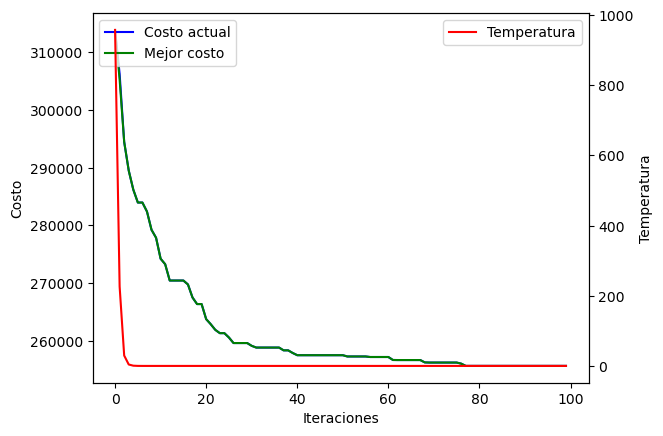

In [52]:
plot_convergence(results_q)

In [53]:
results_q['temp']

[957.5879823193495,
 226.19083422225336,
 29.59213412112011,
 4.034057305453196,
 0.6700450284249777,
 0.09524854349097081,
 0.01516495940671846,
 0.002546745055845424,
 0.0003701268344947191,
 5.898665290515848e-05,
 8.378805110854919e-06,
 1.2410833100431107e-06,
 1.9350382553223107e-07,
 3.018971416082626e-08,
 4.289708182736025e-09,
 7.360342491206801e-10,
 1.2235765952897534e-10,
 1.7765440914427043e-11,
 3.1741681617504675e-12,
 4.750619482623572e-13,
 7.414095411429279e-14,
 1.0542726437913901e-14,
 1.3083726104724678e-15,
 2.0837985543819098e-16,
 3.802728456955459e-17,
 5.93921789286467e-18,
 1.1177170224240264e-18,
 1.9965933451910042e-19,
 2.695471557708662e-20,
 4.248714745947763e-21,
 6.836522337031986e-22,
 1.0235168518159967e-22,
 1.31115750928668e-23,
 1.942109501395668e-24,
 2.7302384615078153e-25,
 3.606811732403292e-26,
 6.582151734011634e-27,
 1.0068333010374393e-27,
 1.5091480841515326e-28,
 2.641380423010839e-29,
 3.792689860767051e-30,
 5.119698331060026e-31,
 8.